<a href="https://colab.research.google.com/github/Diana-codes/Time_Series_Forecasting/blob/main/air_quality_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [6]:
# Setup submission tracking system
def save_submission(predictions, experiment_name, test_index):
    """Save submission with timestamp and experiment info"""
    os.makedirs('submissions', exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    submission = pd.DataFrame({
        'row ID': test_index.strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': predictions.round().astype(int)
    })

    filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission.to_csv(filename, index=False)

    print(f" Submission saved: {filename}")
    print(f" Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")

    return filename, submission

print(" Submission tracking ready!")


 Submission tracking ready!


In [7]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [8]:
# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f" Time range - Train: {train.index.min()} to {train.index.max()}")
print(f" Time range - Test: {test.index.min()} to {test.index.max()}")

# Key insights
if 'pm2.5' in train.columns:
    print(f"\n PM2.5 statistics:")
    print(f"Mean: {train['pm2.5'].mean():.1f}, Std: {train['pm2.5'].std():.1f}")
    print(f"Min: {train['pm2.5'].min():.1f}, Max: {train['pm2.5'].max():.1f}")


 Time range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
 Time range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00

 PM2.5 statistics:
Mean: 100.8, Std: 93.1
Min: 0.0, Max: 994.0


In [9]:
# Handle missing values
print(" Handling missing values...")

# For training data
train_clean = train.copy()
train_clean = train_clean.fillna(method='ffill')  # Forward fill
train_clean = train_clean.fillna(method='bfill')  # Backward fill
train_clean = train_clean.interpolate(method='linear')  # Linear interpolation

# For test data
test_clean = test.copy()
test_clean = test_clean.fillna(method='ffill')
test_clean = test_clean.fillna(method='bfill')
test_clean = test_clean.interpolate(method='linear')

print(f" After treatment - Train: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")
print(f" Clean datasets - Train: {train_clean.shape}, Test: {test_clean.shape}")


 Handling missing values...
 After treatment - Train: 0, Test: 0
 Clean datasets - Train: (30676, 11), Test: (13148, 10)


# Advanced Feature Engineering


In [10]:
def create_advanced_features(df, target_col='pm2.5'):
    """Create lag features, rolling statistics, and temporal features"""
    df_enhanced = df.copy()

    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3

    # Cyclical encoding for temporal features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)

    if target_col in df_enhanced.columns:
        # Lag features for PM2.5
        for lag in [1, 2, 3, 6, 12, 24]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)

        # Rolling statistics for PM2.5
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()

    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']

    # Wind direction features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)

    # Drop original temporal columns (keep encoded versions)
    df_enhanced = df_enhanced.drop(['hour', 'day_of_week', 'month'], axis=1)

    return df_enhanced

def create_test_features(df):
    """Create features for test data (without PM2.5 lag features)"""
    df_enhanced = df.copy()

    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3

    # Cyclical encoding for temporal features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)

    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']

    # Wind direction features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)

    # Drop original temporal columns
    df_enhanced = df_enhanced.drop(['hour', 'day_of_week', 'month'], axis=1)

    return df_enhanced

print(" Feature engineering functions defined.")


 Feature engineering functions defined.


In [18]:
# Apply feature engineering
print(" Creating advanced features...")
train_enhanced = create_advanced_features(train_clean)
test_enhanced = create_test_features(test_clean)

print(f" Original features: {train_clean.shape[1]}")
print(f" Enhanced train features: {train_enhanced.shape[1]}")
print(f" Enhanced test features: {test_enhanced.shape[1]}")
print(f" New features added: {train_enhanced.shape[1] - train_clean.shape[1]}")

# Handle remaining NaNs (from lag and rolling features)
print(" Handling remaining NaN values...")
train_enhanced = train_enhanced.fillna(method='bfill').fillna(0)
test_enhanced = test_enhanced.fillna(method='bfill').fillna(0)

print(f" Final datasets - Train: {train_enhanced.shape}, Test: {test_enhanced.shape}")


 Creating advanced features...
 Original features: 11
 Enhanced train features: 35
 Enhanced test features: 20
 New features added: 24
 Handling remaining NaN values...
 Final datasets - Train: (30676, 35), Test: (13148, 20)


# Model Training and Predictions


In [12]:
# Time series sequence creation
def create_sequences(data, target, sequence_length=24):
    """Create sequences for LSTM input"""
    X, y = [], []

    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])

    return np.array(X), np.array(y)

# Enhanced LSTM model
def create_enhanced_model(input_shape):
    """Create enhanced LSTM model"""
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, activation='tanh'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# Training configuration
SEQUENCE_LENGTH = 24
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

print(" Model architecture defined.")


 Model architecture defined.


In [16]:
# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,893 (1.46 MB)

 Trainable params: 127,297 (497.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 254,596 (994.52 KB)

In [13]:
# Feature alignment for consistent training and testing
print(" Aligning features between train and test...")

# Get common features between train and test
train_feature_cols = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_enhanced.columns if col != 'No']

# Find common features
common_features = [col for col in train_feature_cols if col in test_feature_cols]
print(f" Training features: {len(train_feature_cols)}")
print(f" Test features: {len(test_feature_cols)}")
print(f" Common features: {len(common_features)}")

# Use only common features
X_train_common = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_common = test_enhanced[common_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_common)
X_test_scaled = scaler.transform(X_test_common)

print(f" Feature alignment complete. Using {len(common_features)} common features.")


 Aligning features between train and test...
 Training features: 33
 Test features: 19
 Common features: 19
 Feature alignment complete. Using 19 common features.


In [14]:
# Create sequences and train model
print(" Creating time series sequences...")
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, SEQUENCE_LENGTH)

# Train/validation split
split_idx = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val = y_seq[:split_idx], y_seq[split_idx:]

print(f" Sequences shape: {X_seq.shape}")
print(f" Train: {X_train.shape}, Validation: {X_val.shape}")

# Create and train model
print(" Training enhanced LSTM model...")
model = create_enhanced_model(X_train.shape[1:])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train_seq,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Evaluate model
val_pred = model.predict(X_val, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"\n Model Performance:")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Target: < 3000 RMSE")

if val_rmse < 3000:
    print(" TARGET ACHIEVED!")
else:
    print(f" Need {val_rmse - 3000:.1f} points improvement")


 Creating time series sequences...
 Sequences shape: (30652, 24, 19)
 Train: (24521, 24, 19), Validation: (6131, 24, 19)
 Training enhanced LSTM model...
Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - loss: 12020.4707 - mae: 74.8529 - val_loss: 7903.9741 - val_mae: 56.3388 - learning_rate: 0.0010
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - loss: 4023.7363 - mae: 41.6308 - val_loss: 5878.2983 - val_mae: 50.5433 - learning_rate: 0.0010
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - loss: 2769.5166 - mae: 34.9423 - val_loss: 6113.5918 - val_mae: 51.0991 - learning_rate: 0.0010
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 2257.5256 - mae: 31.6331 - val_loss: 6355.7886 - val_mae: 52.5407 - learning_rate: 0.0010
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - loss: 1811.4814 - mae: 28.3196 - val_loss: 6175.3208 - val_mae: 52.2805 - learning_rate: 0.0010
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - loss: 1505.0261 - mae: 26.0

767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step


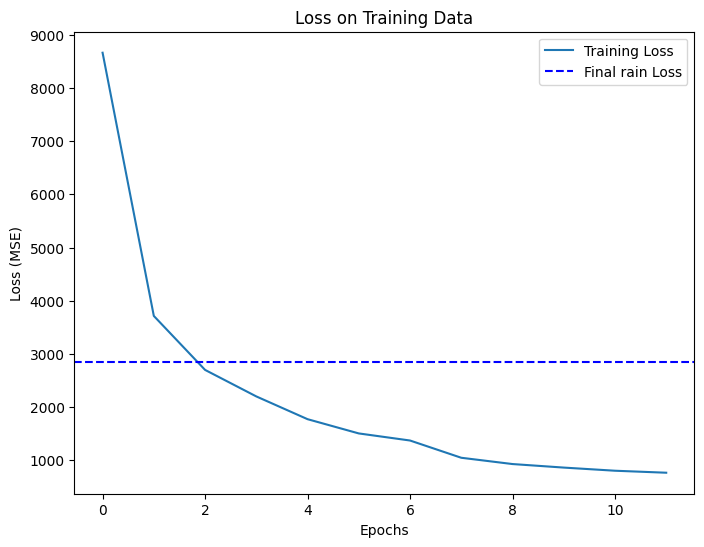

Final Training Loss (MSE): 2845.9211284720845


In [17]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train_seq - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [15]:
# Generate test predictions and create submission
print(" Generating test predictions...")

# Create sequences for test data - FIXED VERSION
test_sequences = []
last_train_sequence = X_train_scaled[-SEQUENCE_LENGTH:]

for i in range(len(X_test_scaled)):
    if i < SEQUENCE_LENGTH:
        # For early predictions, use training data + available test data
        needed_from_train = SEQUENCE_LENGTH - (i + 1)
        if needed_from_train > 0:
            sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
        else:
            sequence = X_test_scaled[:SEQUENCE_LENGTH]
    else:
        # Use sliding window from test data only
        sequence = X_test_scaled[i-SEQUENCE_LENGTH+1:i+1]

    # Ensure sequence is exactly SEQUENCE_LENGTH
    if sequence.shape[0] != SEQUENCE_LENGTH:
        if sequence.shape[0] < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - sequence.shape[0]
            padding = np.repeat(sequence[0:1], padding_needed, axis=0)
            sequence = np.vstack([padding, sequence])
        else:
            sequence = sequence[-SEQUENCE_LENGTH:]

    test_sequences.append(sequence)

# Convert to numpy array - all sequences should now have same shape
X_test_seq = np.array(test_sequences)
print(f" Test sequences shape: {X_test_seq.shape}")

# Generate predictions
print(" Generating predictions...")
test_predictions = model.predict(X_test_seq, verbose=0)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative

print(f" Predictions - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}")

# Create and save submission
experiment_name = f"enhanced_lstm_rmse_{val_rmse:.0f}"
filename, submission = save_submission(
    test_predictions,
    experiment_name,
    test.index
)

print(f"\n EXPERIMENT COMPLETE!")
print(f" Validation RMSE: {val_rmse:.2f}")
print(f" Submission saved: {filename}")
print(f"\n Sample predictions:")
print(submission.head(10))

# Check if submission file exists
import os
if os.path.exists(filename):
    print(f" Confirmed: {filename} exists in submissions folder!")
    print(f" File size: {os.path.getsize(filename)} bytes")
else:
    print(f" Warning: {filename} not found!")


 Generating test predictions...
 Test sequences shape: (13148, 24, 19)
 Generating predictions...
 Predictions - Min: 11.0, Max: 255.5
 Submission saved: submissions/20250921_205326_enhanced_lstm_rmse_77.csv
 Predictions - Min: 11.0, Max: 255.5

 EXPERIMENT COMPLETE!
 Validation RMSE: 76.67
 Submission saved: submissions/20250921_205326_enhanced_lstm_rmse_77.csv

 Sample predictions:
                row ID  pm2.5
0   2013-07-02 4:00:00     41
1   2013-07-02 5:00:00     41
2   2013-07-02 6:00:00     41
3   2013-07-02 7:00:00     40
4   2013-07-02 8:00:00     38
5   2013-07-02 9:00:00     36
6  2013-07-02 10:00:00     32
7  2013-07-02 11:00:00     30
8  2013-07-02 12:00:00     28
9  2013-07-02 13:00:00     26
 Confirmed: submissions/20250921_205326_enhanced_lstm_rmse_77.csv exists in submissions folder!
 File size: 301500 bytes
